In [1]:
import torch
from torch import Tensor
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal

from etna.datasets import TSDataset, generate_ar_df
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/Users/a.p.chikov/Library/Caches/pypoetry/virtualenvs/etna-ts-5LkX4_TY-py3.8/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
%load_ext autoreload
%autoreload 2

# Data generation

In [3]:
from etna.models.nn.deepstate import LevelSSM, LevelTrendSSM, SeasonalitySSM

In [158]:
def generate_dataset(ssm, datetime_index, seq_length:int, n_groups:int, n_samples:int) -> TSDataset:
    # Parameters
    prior_mean = torch.randint(1, 100, size=(n_groups, ssm.latent_dim())).float()
    prior_std = torch.rand(size=(n_groups, ssm.latent_dim())).float()
    prior_cov = torch.diag_embed(prior_std * prior_std)
    noise_std = torch.rand(size=(n_groups * n_samples, seq_length, 1)).float()
    inovation_std = torch.rand(size=(n_groups * n_samples, seq_length, ssm.latent_dim())).float()
    
    emission_coeff = ssm.emission_coeff(datetime_index)
    transition_coeff = ssm.transition_coeff()
    innovation_coeff = ssm.innovation_coeff(datetime_index) * inovation_std
    
    eps_latent = MultivariateNormal(torch.zeros(ssm.latent_dim()), torch.eye(ssm.latent_dim())).sample(
            (n_groups * n_samples, seq_length)
        )
    eps_observation = Normal(0, 1).sample((n_groups * n_samples, seq_length, 1))

    # Data
    l_t = MultivariateNormal(prior_mean, prior_cov).sample((n_samples, )).reshape(-1, ssm.latent_dim())
    zs = []
    for t in range(seq_length):
        z_t = (emission_coeff[:, t].unsqueeze(-1).permute(0, 2, 1) @ l_t.unsqueeze(-1)).squeeze(-1) + noise_std[:, t] * eps_observation[:, t]
        l_t = (transition_coeff @ l_t.unsqueeze(-1)).squeeze(-1) + innovation_coeff[:, t] * eps_latent[:, t]
        zs.append(z_t)
    target = torch.cat(zs, dim=1).numpy().reshape(-1)
    
    # Dataset
    df = generate_ar_df(periods=seq_length, n_segments=n_groups*n_samples, start_time="2000-01-01")
    df["target"] = target
    df["group"] = [group for sample in range(n_samples) for group in range(n_groups) for _ in range(seq_length)]
    df["datetime_index"] = datetime_index.numpy().reshape(-1)
    df = TSDataset.to_dataset(df)
    ts = TSDataset(df, "D")
    
    return ts, prior_mean, prior_std, noise_std, inovation_std

In [159]:
n_groups = 3
n_samples = 20
seq_length = 70
ssm = SeasonalitySSM(num_seasons=7)
#datetime_index = torch.randint(1, 100, size=(n_groups * n_samples, seq_length, 1)).to(torch.int64)
datetime_index = torch.Tensor(np.arange(seq_length) % 7).repeat(n_groups * n_samples, 1).to(torch.int64)
ts, prior_mean, prior_std, noise_std, inovation_std = generate_dataset(ssm, datetime_index, seq_length, n_groups, n_samples)

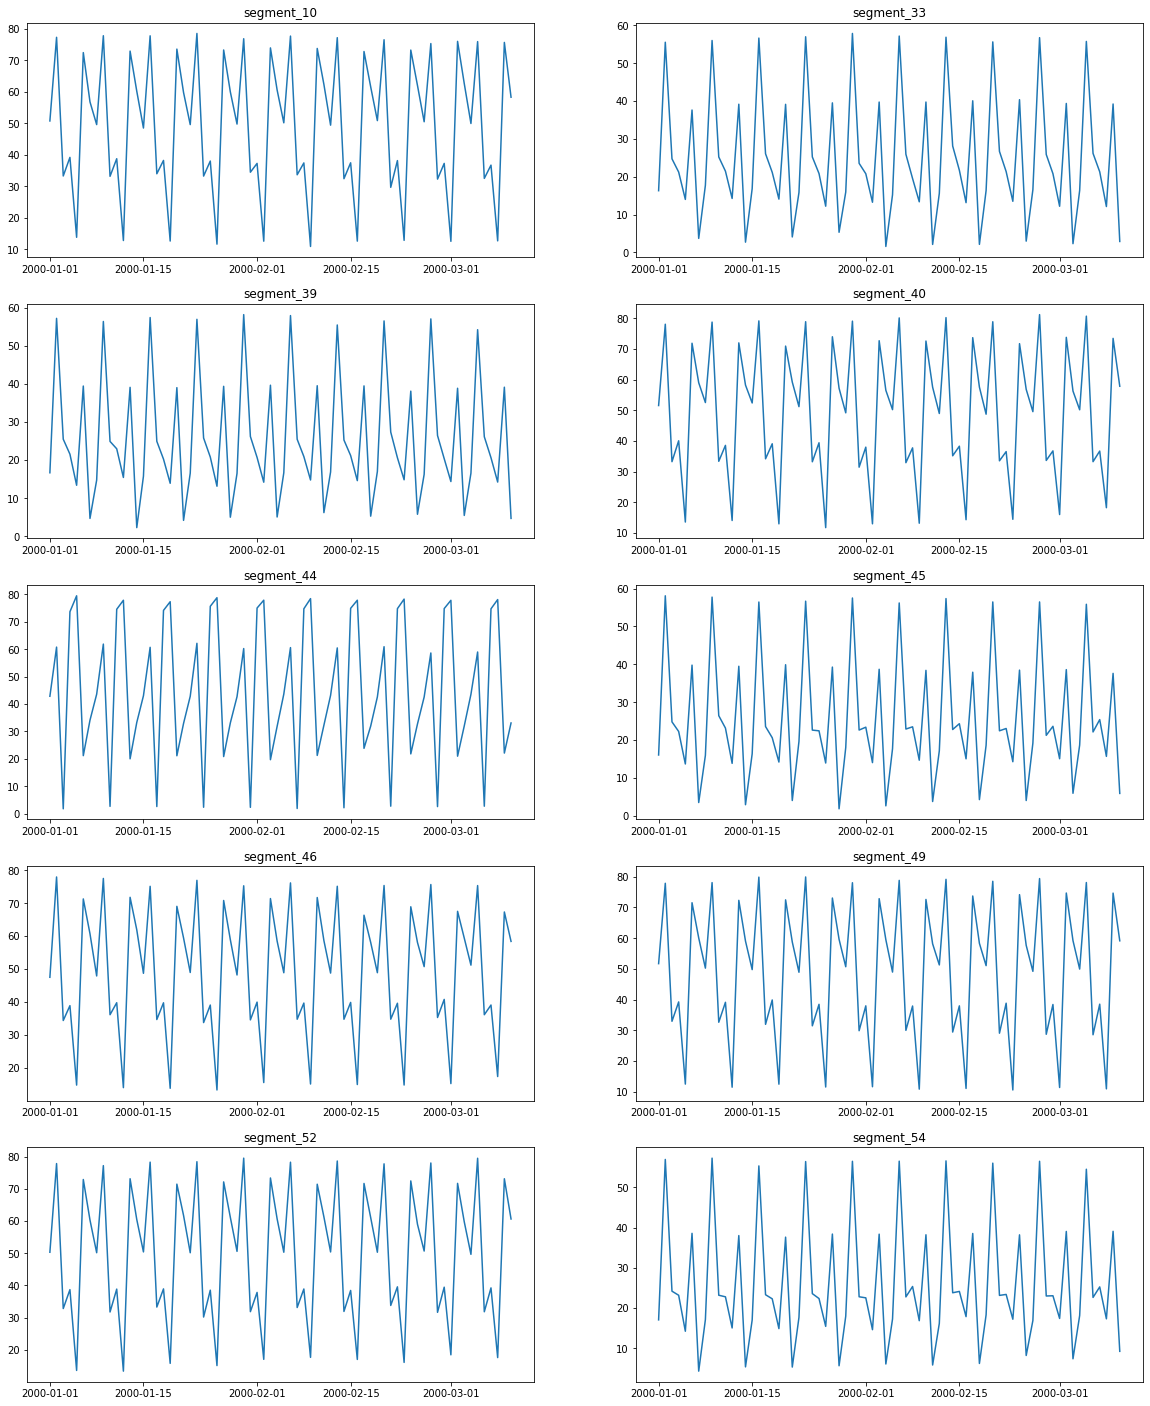

In [160]:
ts.plot(n_segments=10)

In [161]:
from etna.transforms import LagTransform, StandardScalerTransform

In [162]:
ts.fit_transform([StandardScalerTransform(in_column="target"), LagTransform(in_column="target", lags=list(range(2, 15)), out_column="lag")])

In [163]:
encoder_len = 21
train_loader = ts.to_train_dataloader(encoder_length=encoder_len, decoder_length=0, columns_to_add=[f"lag_{i}" for i in range(2, 8)], datetime_index="datetime_index", batch_size=32)

# Model

In [164]:
from etna.models.nn.deepstate import DeepStateNetwork, LDS
from pytorch_lightning import Trainer

In [165]:
model = DeepStateNetwork(ssm, n_samples=10, input_size=7)

In [166]:
trainer = Trainer()
trainer.fit(model=model, train_dataloader=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/a.p.chikov/Library/Caches/pypoetry/virtualenvs/etna-ts-5LkX4_TY-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name       | Type       | Params
------------------------------------------
0 | RNN        | LSTM       | 448   
1 | projectors | ModuleDict | 176   
------------------------------------------
624       Trainable params
0         Non-trainable params
624       Total params
0.002     Total estimated model params size (MB)
/Users/a.p.chikov/Library/Caches/pypoetry/virtualenvs/etna-ts-5LkX4_TY-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have ma

Training: 0it [00:00, ?it/s]

/Users/a.p.chikov/Library/Caches/pypoetry/virtualenvs/etna-ts-5LkX4_TY-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
